# Training a classifier on a real dataset.

## Task:
We need to train a classifier that determines the type of bicycle on a small dataset of bicycle photos from public sources.

Analyze the data and select the appropriate tools and metrics to address this challenge.

You may use pre-trained models from torchvision.models.
Write a report on the results.

# Data

In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

--2024-11-28 09:36:24--  http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110280897 (105M) [application/zip]
Saving to: ‘bt_dataset3.zip’

bt_dataset3.zip     100%[===================>] 105.17M  6.79MB/s    in 22s     

2024-11-28 09:36:47 (4.73 MB/s) - ‘bt_dataset3.zip’ saved [110280897/110280897]



In [ ]:
! unzip bt_dataset3.zip

Archive:  bt_dataset3.zip
   creating: bike/
   creating: bike/bike_type/
   creating: bike/bike_type/train/
   creating: bike/bike_type/train/road/
  inflating: bike/bike_type/train/road/road_4884_5fccd8907cba8.jpeg  
  inflating: bike/bike_type/train/road/road_2553_5fccd83752957.jpeg  
  inflating: bike/bike_type/train/road/road_87_5fccd85402f10.jpeg  
  inflating: bike/bike_type/train/road/road_2457_5fccd81a0919f.jpeg  
  inflating: bike/bike_type/train/road/road_3543_5fccd81d36d22.jpeg  
  inflating: bike/bike_type/train/road/road_85_5fccd8080cc2e.jpeg  
  inflating: bike/bike_type/train/road/road_2515_5fccd8591c9fa.jpeg  
  inflating: bike/bike_type/train/road/road_1965_5fccd81e7e8a4.jpeg  
  inflating: bike/bike_type/train/road/road_2663_5fccd892cdad1.jpeg  
  inflating: bike/bike_type/train/road/road_2297_5fccd83b36a41.jpeg  
  inflating: bike/bike_type/train/road/road_2115_5fccd82b972c0.jpeg  
  inflating: bike/bike_type/train/road/road_2852_5fccd80ab6871.jpeg  
  inflating: bi

In [1]:
!pip install wandb --upgrade --quiet
!pip install torchmetrics

In [2]:
import wandb

In [3]:
!wandb login

wandb: Currently logged in as: kivcich (kivcich-hse). Use `wandb login --relogin` to force relogin


# Solution

In [27]:
import datetime
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm.auto import tqdm
import warnings
from IPython.display import clear_output
from tqdm import tqdm
import torch
from torchmetrics.functional import precision, f1_score
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
val_parent = '../content/bike/bike_type/val'
train_parent = '../content/bike/bike_type/train'

In [7]:
class RealDataSet(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.transform = transform
    self.len_dataset = 0
    self.data_list = []

    for path_dir, dir_list, file_list in os.walk(path):
      if path_dir == path:
        self.classes = dir_list
        self.class_to_idx = {
            cls_name: i for i, cls_name in enumerate(self.classes)
        }
        continue

      cls = path_dir.split('/')[-1]

      for name_file in file_list:
        file_path = os.path.join(path_dir, name_file)
        self.data_list.append((file_path, self.class_to_idx[cls]))

      self.len_dataset += len(file_list)

  def __len__(self):
    return self.len_dataset

  def __getitem__(self, idx):
    file_path, target = self.data_list[idx]
    sample = np.array(Image.open(file_path))

    if self.transform is not None:
      sample = self.transform(sample)

    return sample, target

При просмотре данных было замечено, что классы имеют дисбаланс, а также картинки представлены разных размеров. Данные обстоятельства могут мешать модели, поэтому требуется с ними поработать

In [8]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_data = ImageFolder(root=train_parent, transform=transform)
val_data = ImageFolder(root=val_parent, transform=transform)

In [10]:
train_data.classes

['bmx', 'child', 'city', 'mtb', 'road']

In [11]:
train_data.class_to_idx

{'bmx': 0, 'child': 1, 'city': 2, 'mtb': 3, 'road': 4}

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True, num_workers=4
)

val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=32, shuffle=False, num_workers=4
)

In [13]:
def get_sizes(train, val):
  widths = []
  heights = []

  for img, _ in train:
      widths.append(img.shape[1])
      heights.append(img.shape[2])

  for img, _ in val:
      widths.append(img.shape[1])
      heights.append(img.shape[2])

  plt.figure(figsize=(10, 6))
  plt.scatter(widths, heights, alpha=0.5)
  plt.title('Размеры изображений')
  plt.xlabel('Ширина (пиксели)')
  plt.ylabel('Высота (пиксели)')
  plt.grid()
  plt.show()

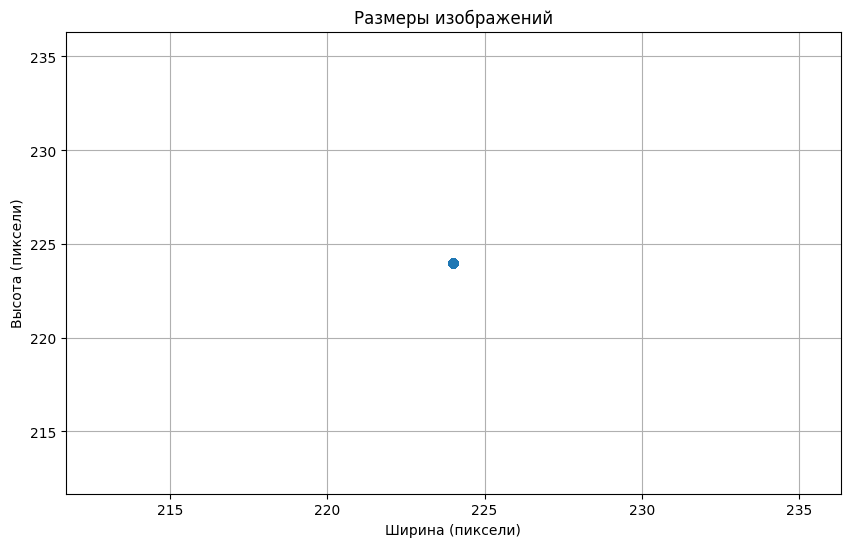

In [14]:
get_sizes(train_data, val_data)

In [15]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
import torch
from torchmetrics.functional import precision, f1_score

warnings.filterwarnings("ignore")
%matplotlib inline

def train_new(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=6):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        train_epoch_precisions, train_epoch_f1_scores = torch.empty(0), torch.empty(0)
        model.train()  # режим тренировки

        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch+1}", leave=True):
            imgs, labels = imgs.to(device), labels.to(device)

            # прямой проход
            y_pred = model(imgs)
            # вычисление потерь
            loss = criterion(y_pred, labels)
            # обратное распространение ошибки
            loss.backward()
            # обновление параметров модели на основе градиентов
            optimizer.step()
            # сброс градиентов до нуля
            optimizer.zero_grad()

            # логирование потерь для текущей эпохи и всех эпох
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # логирование точности для текущей эпохи и всех эпох
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)  # предсказанные классы
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

            # Precision и F1-score
            batch_precision = precision(pred_classes, labels.cpu(), average="macro", task='multiclass', num_classes=len(train_dataloader.dataset.classes))
            batch_f1_score = f1_score(pred_classes, labels.cpu(), average="macro", task='multiclass', num_classes=len(train_dataloader.dataset.classes))

            train_epoch_precisions = torch.cat((train_epoch_precisions, batch_precision.unsqueeze(0)))
            train_epoch_f1_scores = torch.cat((train_epoch_f1_scores, batch_f1_score.unsqueeze(0)))

        # валидация на текущей эпохе
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        val_epoch_precisions, val_epoch_f1_scores = torch.empty(0), torch.empty(0)
        model.eval()

        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)

                # прямой проход
                y_pred = model(imgs)
                # вычисление потерь
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                # предсказанные классы
                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

                # Precision и F1-score для валидации
                batch_precision = precision(pred_classes, labels.cpu(), average="weighted", task='multiclass', num_classes=len(val_dataloader.dataset.classes))
                batch_f1_score = f1_score(pred_classes, labels.cpu(), average="weighted", task='multiclass', num_classes=len(val_dataloader.dataset.classes))

                val_epoch_precisions = torch.cat((val_epoch_precisions, batch_precision.unsqueeze(0)))
                val_epoch_f1_scores = torch.cat((val_epoch_f1_scores, batch_f1_score.unsqueeze(0)))

        # логирование
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size
        )
        clear_output()

        # логирование
        wandb.log(
            {
                "Train loss": train_epoch_loss.mean().item(),
                "Train acc": (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item(),
                "Train precision": train_epoch_precisions.mean().item(),
                "Train F1-score": train_epoch_f1_scores.mean().item(),
                "Val loss": val_epoch_loss.mean().item(),
                "Val acc": (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item(),
                "Val precision": val_epoch_precisions.mean().item(),
                "Val F1-score": val_epoch_f1_scores.mean().item(),
            }
        )

        # логирование в консоль
        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item(),
        )
        print("Train precision:", train_epoch_precisions.mean().item())
        print("Train F1-score:", train_epoch_f1_scores.mean().item())
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item(),
        )
        print("Val precision:", val_epoch_precisions.mean().item())
        print("Val F1-score:", val_epoch_f1_scores.mean().item())


In [16]:
class EffModel(nn.Module):
    def __init__(self, num_classes):
        super(EffModel, self).__init__()
        # EfficientNet с предобученными весами
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        # извлечение количества входных признаков последнего слоя
        self.in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),  # Dropout
            nn.Linear(self.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [17]:
model = EffModel(5).to(device)
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.0001) # оптмизатор для град. спуска

In [18]:
# инициализируем проект
wandb.init(project="EX3_more")
wandb.watch(model);

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kivcich (kivcich-hse). Use `wandb login --relogin` to force relogin


In [19]:
train_new(model, criterion, optimizer, train_dataloader, val_dataloader)

Train loss: 0.014211313799023628
Train acc: 0.8311631679534912
Train precision: 0.7936391234397888
Train F1-score: 0.767733633518219
Val loss: 0.028619129210710526
Val acc: 0.6708333492279053
Val precision: 0.9726617932319641
Val F1-score: 0.8008889555931091


In [30]:
def valid(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model(imgs)

            pred_classes = torch.argmax(y_pred, dim=-1)
            all_predictions.extend(pred_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # вычисление метрик
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    # вывод
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")


In [31]:
valid(model, criterion, val_dataloader)

Accuracy: 0.751
Precision: 0.753
Recall: 0.751
F1 Score: 0.750


# Report
По итогам задания получились следующие метрики:
- Accuracy: 0.751
- Precision: 0.753
- Recall: 0.751
- F1 Score: 0.750

##Итоги:
- Accuracy = 0.751 означает, что 75.1% предсказаний модели оказались правильными. Это общее значение, которое показывает, насколько хорошо модель справляется с задачей в целом, но не стоит полгалаться только на этот показатель - текщая задача имеет плохо сбалансированные классы.

- Precision = 0.753 указывает на то, что из всех предсказанных положительных случаев, 73.9% действительно являются положительными. Этот показатель достаточно важен, так как неплохо бореться с дисбалансом.

- Recall = 0.744 показывает, что модель смогла верно идентифицировать 74.4% реальных положительных случаев. Высокий recall указывает на то, что модель не пропускает много важных случаев.

- F1 Score: 0.738 является гармоническим средним между precision и recall, а данный результат имеет достаточно высокий показатель
